## 第五章 全连接神经网络 回归


In [9]:
# %config InlineBackend.figure_format = 'retina'
# %matplotlib inline

## 导入本章所需要的模块
import numpy as np
import pandas as pd

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import hiddenlayer as hl

本章节回归分析时使用california房屋价格数据

该数据集源自1990年美国人口普查，每行样本是每个人口普查区块组的数据。 区块组通常拥有600至3,000人口。

目标变量是每个区块组房价的中位数

### 数据准备和探索

In [16]:
## 导入数据
housdata = fetch_california_housing()

In [7]:
housdata.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [21]:
train_test_split?

In [22]:
## 数据切分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    housdata.data, housdata.target, test_size=0.3, random_state=42)

In [23]:
## 数据标准化处理
scale = StandardScaler()
X_train_s = scale.fit_transform(X_train)
X_test_s = scale.transform(X_test)
# 标准化处理完之后返回值是ndarray类型

In [30]:
StandardScaler?

In [24]:
## 将训练集数据处理为数据表，方便探索数据情况
housdatadf = pd.DataFrame(data=X_train_s,columns=housdata.feature_names)

In [25]:
housdatadf.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.133506,0.509357,0.181060,-0.273850,-0.184117,-0.010825,-0.805682,0.780934
1,-0.532218,-0.679873,-0.422630,-0.047868,-0.376191,-0.089316,-1.339473,1.245270
2,0.170990,-0.362745,0.073128,-0.242600,-0.611240,-0.044800,-0.496645,-0.277552
3,-0.402916,-1.155565,0.175848,-0.008560,-0.987495,-0.075230,1.690024,-0.706938
4,-0.299285,1.857152,-0.259598,-0.070993,0.086015,-0.066357,0.992350,-1.430902


In [26]:
housdatadf["target"] = y_train
housdatadf.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,0.133506,0.509357,0.181060,-0.273850,-0.184117,-0.010825,-0.805682,0.780934,1.93800
1,-0.532218,-0.679873,-0.422630,-0.047868,-0.376191,-0.089316,-1.339473,1.245270,1.69700
2,0.170990,-0.362745,0.073128,-0.242600,-0.611240,-0.044800,-0.496645,-0.277552,2.59800
3,-0.402916,-1.155565,0.175848,-0.008560,-0.987495,-0.075230,1.690024,-0.706938,1.36100
4,-0.299285,1.857152,-0.259598,-0.070993,0.086015,-0.066357,0.992350,-1.430902,5.00001


In [4]:
# ## 将训练集数据处理为数据表，方便探索数据情况
# housdatadf = pd.DataFrame(data=housdata.data,columns=housdata.feature_names)
# housdatadf["target"] = housdata.target
# housdatadf.head()

In [5]:
# sns.kdeplot(housdatadf.AveBedrms,gridsize=100)

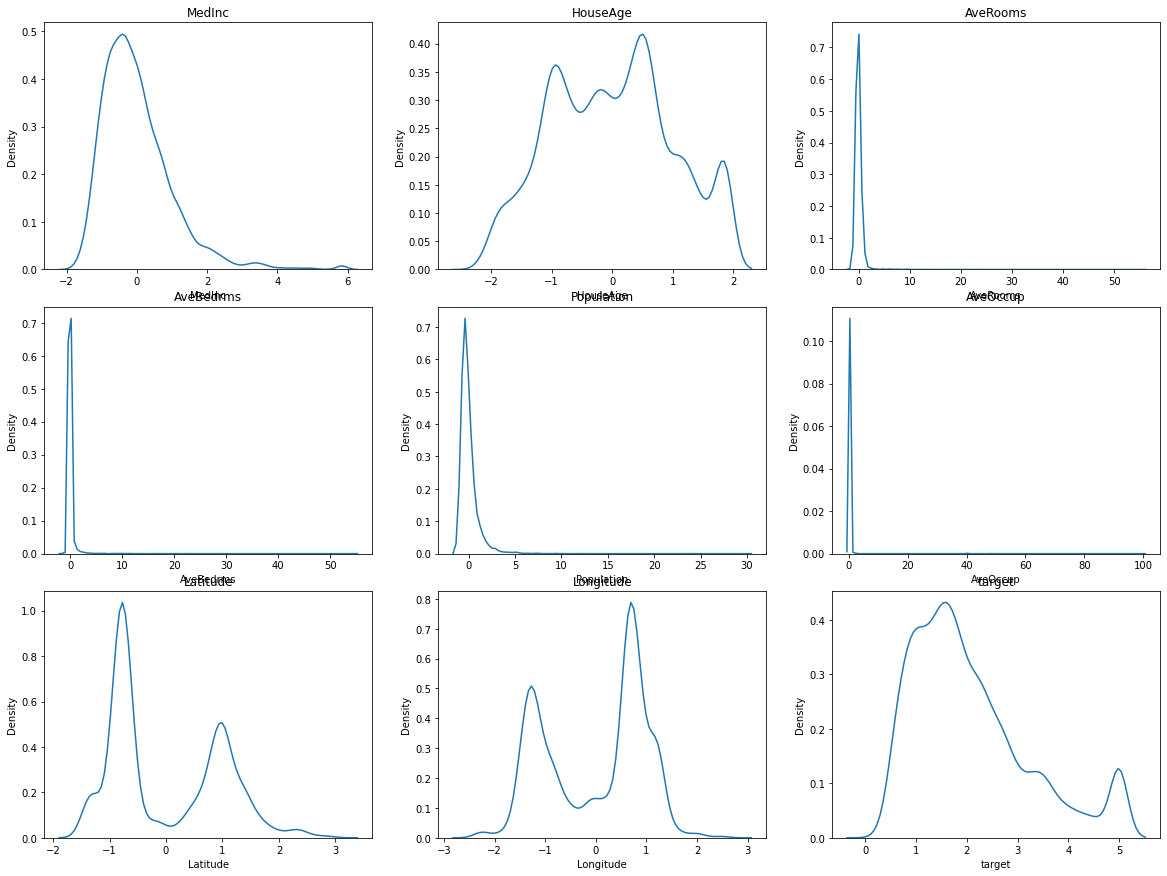

In [27]:
## 可视化每个变量的数据分布
colname = housdatadf.columns.values
plt.figure(figsize=(20,15))
for ii in range(len(colname)):
    plt.subplot(3,3,ii+1)
    sns.kdeplot(housdatadf[colname[ii]],gridsize=100)
    plt.title(colname[ii])
plt.subplots_adjust(hspace=0.15)
plt.show()

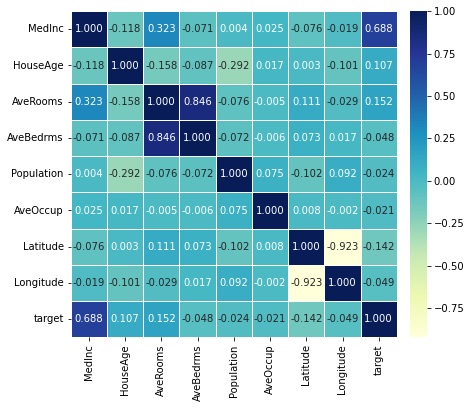

In [28]:
## 可视化数据的相关系数热力图
datacor = np.corrcoef(housdatadf.values,rowvar=0)

datacor = pd.DataFrame(data=datacor,columns=housdatadf.columns,
                       index=housdatadf.columns)
plt.figure(figsize=(8,6))
ax = sns.heatmap(datacor,square=True,annot=True,fmt = ".3f",
                 linewidths=.5,cmap="YlGnBu",
                 cbar_kws={"fraction":0.046, "pad":0.03})
plt.show()

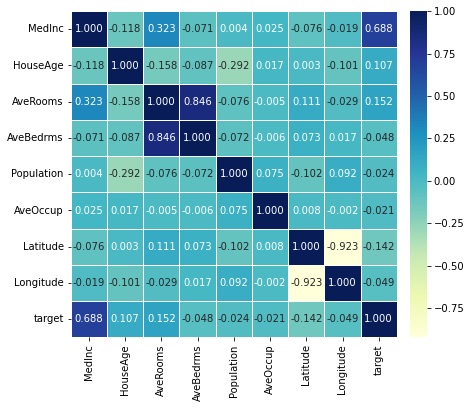

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(housdatadf.corr(),square=True,annot=True,fmt = ".3f",
            linewidths=.5,cmap="YlGnBu",
            cbar_kws={"fraction":0.046, "pad":0.03})
plt.show()

In [32]:
## 将数据集转化为张量
train_xt = torch.from_numpy(X_train_s.astype(np.float32))
train_yt = torch.from_numpy(y_train.astype(np.float32))
test_xt = torch.from_numpy(X_test_s.astype(np.float32))
test_yt = torch.from_numpy(y_test.astype(np.float32))

# astype是numpy的内容，数据类型转化

In [34]:
Data.TensorDataset?

In [ ]:
## 将训练数据为数据加载器
train_data = Data.TensorDataset(train_xt,train_yt)
test_data = Data.TensorDataset(test_xt,test_yt)
train_loader = Data.DataLoader(dataset = train_data,batch_size=64,
                               shuffle = True,num_workers = 1)
# test_loader = Data.DataLoader(dataset = test_data, batch_size=64,
#                               shuffle = True,num_workers = 1)

In [35]:
# ##  检查训练数据集的一个batch的样本的维度是否正确
# for step, (b_x, b_y) in enumerate(train_loader):  
#     if step > 0:
#         break
## 输出训练图像的尺寸和标签的尺寸，和数据类型
# print("b_x.shape:",b_x.shape)
# print("b_y.shape:",b_y.shape)
# print("b_x.dtype:",b_x.dtype)
# print("b_y.dtype:",b_y.dtype)

In [43]:
## 搭建全连接神经网络回归网络
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        ## 定义第一个隐藏层
        self.hidden1 = nn.Linear(in_features = 8,
                                 out_features = 100,bias=True)
        ## 定义第二个隐藏层
        self.hidden2 = nn.Linear(100,100)
        ## 定义第三个隐藏层
        self.hidden3 = nn.Linear(100,50)
        ## 回归预测层
        self.predict = nn.Linear(50,1)

    ## 定义网络的向前传播路径   
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        output = self.predict(x)
        ## 输出一个一维向量
        return output[:,0]

In [39]:
MLPregression?

In [44]:
## 输出我们的网络结构
mlpreg = MLPregression()
print(mlpreg)

MLPregression(
  (hidden1): Linear(in_features=8, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)


In [42]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
mlpreg = Model()
print(mlpreg)

Model(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
)


### 训练和测试MLP回归网络

In [45]:
torch.optim.SGD?

In [46]:
# 定义优化器
optimizer = torch.optim.SGD(mlpreg.parameters(),lr=0.01)  
loss_func = nn.MSELoss()   # 均方根误差损失函数
train_loss_all = []
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(30):
    train_loss = 0
    train_num = 0
    ## 对训练数据的迭代器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):  
        output = mlpreg(b_x)               # MLP在训练batch上的输出
        loss = loss_func(output, b_y)  # 均方根误差损失函数
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        loss.backward()           # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        train_loss += loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(train_loss / train_num)

In [47]:
train_loss_all

[1.0599156163657621,
 0.515662969280847,
 0.45518265494608534,
 0.42733527312379077,
 0.40941608470275687,
 0.39552595221323034,
 0.384501942764485,
 0.37642580234463163,
 0.3688175376929582,
 0.3622370452051807,
 0.35620997171201313,
 0.35083876035340206,
 0.34627756185969905,
 0.342425970358574,
 0.3377192659037454,
 0.33581982069501315,
 0.3305719463796183,
 0.3282420766908069,
 0.32326389728722515,
 0.3218707887833301,
 0.3186055583547252,
 0.31525362118798106,
 0.31257597186240643,
 0.31397999910553165,
 0.30860109543087477,
 0.30686322323243614,
 0.3061084884939796,
 0.304127823920345,
 0.3016915287686345,
 0.3025690850823425]

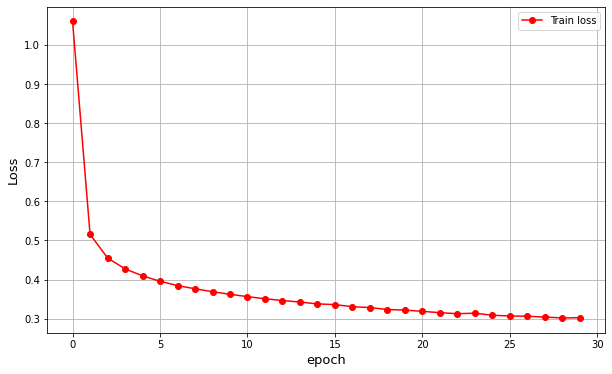

In [48]:
## 可视化损失函数的变化情况
plt.figure(figsize=(10,6))
plt.plot(train_loss_all,"ro-",label = "Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch",size = 13)
plt.ylabel("Loss",size = 13)
plt.show()

In [49]:
## 对测试集进行预测
pre_y = mlpreg(test_xt)

In [51]:
a = torch.zeros([2, 4], dtype=torch.int32)

In [52]:
a

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.int32)

In [55]:
a=a.data.numpy

In [56]:
a

<function Tensor.numpy>

In [50]:
pre_y

tensor([0.7062, 1.2503, 4.7003,  ..., 2.0578, 1.2645, 1.9031],
       grad_fn=<SelectBackward0>)

In [57]:
pre_y = pre_y.data.numpy()

In [58]:
pre_y

array([0.70622313, 1.2503197 , 4.700274  , ..., 2.0577612 , 1.2645336 ,
       1.9030597 ], dtype=float32)

In [59]:
mae = mean_absolute_error(y_test,pre_y)
print("在测试集上的绝对值误差为:",mae)

在测试集上的绝对值误差为: 0.3844580164393282


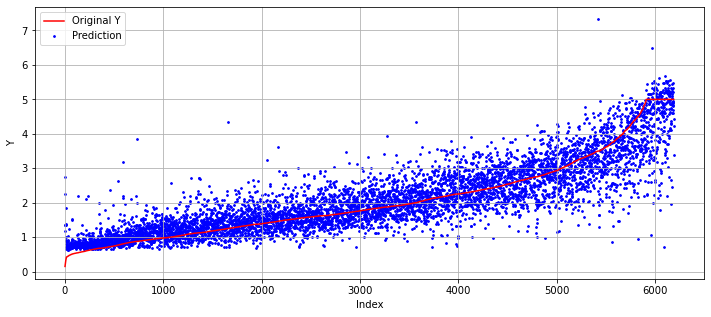

In [60]:
## 可视化在测试集上真实值和预测值的差异
index = np.argsort(y_test)
plt.figure(figsize=(12,5))
plt.plot(np.arange(len(y_test)),y_test[index],"r",label = "Original Y")
plt.scatter(np.arange(len(pre_y)),pre_y[index],s = 3,c = "b",label = "Prediction")
plt.legend(loc = "upper left")
plt.grid()
plt.xlabel("Index")
plt.ylabel("Y")
plt.show()